## ================== Naive Bayes for Text Classification =============

##### Wordcloud Link:  : https://medium.com/analytics-vidhya/data-visualization-word-clouds-with-python-fbb6395be18f
##### Scikit Learn Link: https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
##### Count Vectorize Lib: https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
##### Multinomial NB Lib:  https://scikit-learn.org/dev/modules/generated/sklearn.naive_bayes.MultinomialNB.html


In [1]:
use_stopwords   = 1
use_tokenize    = 1
use_lemmatizer  = 1
use_stemmer     = 1
use_bigrams     = 0    # why accuracy is decreasig with bigrams? # it did not happen with scikit-learn
balance_dataset = 1    # if some class has less proportion in training dataset, duplicate it sufficient times
use_lap_smooth  = 1    # laplace smoothing for unseen words, which does not appear in current class; but might/might-not appear in other classes

# regular naive bayes accuracy = 0.55
# + tokenize                   = 0.59
# + stopword removal           = 0.59
# + lemmatizer & stemmer       = 0.63  (strangely lematizer gave only 0.61; stemmer gave 0.629 ~ 0.63) 
# + balance_dataset            = 0.67  (note that this opposes the generative probabilities of choosing classes initially based on size of each class)
# + scikit-learn               = 0.7   (don't know why it is better?)

assert (use_stopwords   == 1 or use_stopwords   == 0)
assert (use_tokenize    == 1 or use_tokenize    == 0)
assert (use_lemmatizer  == 1 or use_lemmatizer  == 0)
assert (use_stemmer     == 1 or use_stemmer     == 0)
assert (use_bigrams     == 1 or use_bigrams     == 0)
assert (balance_dataset == 1 or balance_dataset == 0)
assert (use_lap_smooth  == 1 or use_lap_smooth  == 0)

### Reading training data from .csv file

In [2]:
import os
import pandas as pd

__location__ = os.path.realpath(os.path.join(os.getcwd(), "dataset_corona_sentiment/Corona_train.csv"))
df_train = pd.read_csv(__location__)



In [3]:
print ("number of rows    :", df_train.shape[0])
print ("number of columns :", df_train.shape[1])
print ("column values     :", list(df_train.columns.values))

print ("\ndistribution of class lebels :", dict(df_train['Sentiment'].value_counts()))
print ("\ndata frame: \n\n", df_train, sep='\n')                                          # sep='\n' does not indent new line
print ("\nfirst row item  :", dict(df_train.iloc[0]))

number of rows    : 37864
number of columns : 3
column values     : ['ID', 'Sentiment', 'CoronaTweet']

distribution of class lebels : {'Positive': 16602, 'Negative': 14166, 'Neutral': 7096}

data frame: 


          ID Sentiment                                        CoronaTweet
0      22979  Positive  I see all kinds of academics already whipping ...
1       9880  Negative  @HenrySmithUK can you raise with Boris please ...
2      35761  Negative  It s a confusing odd time for the shopping pub...
3      37968  Positive  Blog Summary: The Impact of COVID-19 on the Ca...
4      19709   Neutral  ??????? ??????? ???\r\r\nWaiting in a long Que...
...      ...       ...                                                ...
37859  20253   Neutral  DOUBLE TAP ??IF YOU REMEMBER BEING EMPLOYED?\r...
37860  38926  Positive  Struggling to understand why supermarkets or f...
37861  35889  Positive  For anyone interested in the checklist on cons...
37862  40641  Positive  Do you agree with the hypothe

### Balance Dataset

In [4]:
if balance_dataset == 1:
    df_train_net = df_train[df_train.Sentiment == 'Neutral']
    df_train = pd.concat([df_train, df_train_net])
print ("\ndistribution of class lebels :", dict(df_train['Sentiment'].value_counts()))


distribution of class lebels : {'Positive': 16602, 'Neutral': 14192, 'Negative': 14166}


### Converting to Lists

In [5]:
y_train = list(df_train['Sentiment'])
x_train = list(df_train['CoronaTweet'])

In [6]:
#print ("number of data points     :", len(x_train))
#print ("number of class labels    :", len(y_train))
assert(len(x_train) == len(y_train))

### Filter Each Class & Collect Vocab for Each

In [7]:
x_train_pos_df = df_train[df_train.Sentiment == 'Positive']['CoronaTweet']
x_train_neg_df = df_train[df_train.Sentiment == 'Negative']['CoronaTweet']
x_train_net_df = df_train[df_train.Sentiment == 'Neutral' ]['CoronaTweet']
#print ("positive labeled data frame: \n", x_train_pos, sep='\n')

In [8]:
x_train_pos_lst = list(x_train_pos_df)
x_train_neg_lst = list(x_train_neg_df)
x_train_net_lst = list(x_train_net_df)
#print ("first few positively labeled tweets: ", x_train_pos_lst[:2])

In [9]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

pos_word_list = []
neg_word_list = []
net_word_list = []
for tweet in x_train_pos_lst:
    if use_tokenize == 1:
        pos_word_list.extend(word_tokenize(tweet))
    else:
        pos_word_list.extend(tweet.split())
for tweet in x_train_neg_lst:
    if use_tokenize == 1:
        neg_word_list.extend(word_tokenize(tweet))
    else:
        neg_word_list.extend(tweet.split())
for tweet in x_train_net_lst:
    if use_tokenize == 1:
        net_word_list.extend(word_tokenize(tweet))
    else:
        net_word_list.extend(tweet.split())
    
print ("first few words in dictionary of poitively labeled tweets", pos_word_list[:100])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dishantgoyal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


first few words in dictionary of poitively labeled tweets ['I', 'see', 'all', 'kinds', 'of', 'academics', 'already', 'whipping', 'up', 'some', '#', 'Covid_19', 'related', 'projects', ',', 'cfp', ',', 'syllabi', ',', 'articles', ',', 'and', 'blog', 'posts', '.', 'IÂ\x92m', 'sittin', 'over', 'here', 'browsing', 'all', 'the', 'food', 'left', '&', 'amp', ';', 'tryin', 'to', 'figure', 'out', 'when', 'to', 'go', 'back', 'out', 'to', 'the', 'grocery', 'store', '.', 'Apparently', 'I', 'donÂ\x92t', 'do', 'well', 'in', 'pandemic', 'Blog', 'Summary', ':', 'The', 'Impact', 'of', 'COVID-19', 'on', 'the', 'Canadian', 'Residential', 'Housing', 'Market', 'with', 'data', 'from', '@', 'local_logic', 'https', ':', '//t.co/yLy8vYzH2r', '--', '&', 'gt', ';', 'Download', 'the', 'full', 'report', 'here', 'https', ':', '//t.co/Y2PDlSteYr', 'If', 'youÂ\x92re', 'running', 'a', '#', 'smallbusiness', 'you', 'need', 'to']


### Wordcloud

a few stop words: 

ours
above
doesn't
and
each
him
i'd
where's
how's
than

word cloud for positively labeled items: 


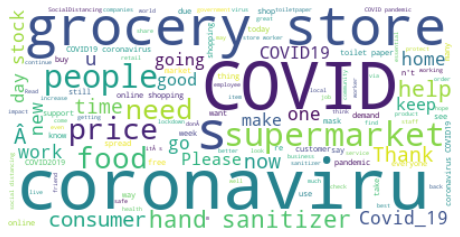


word cloud for negatively labeled items: 


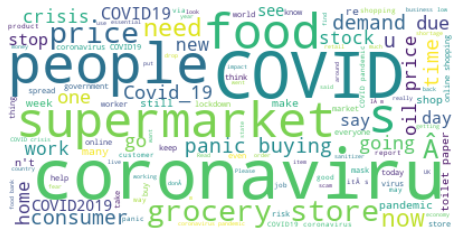


word cloud for neutral labeled items: 


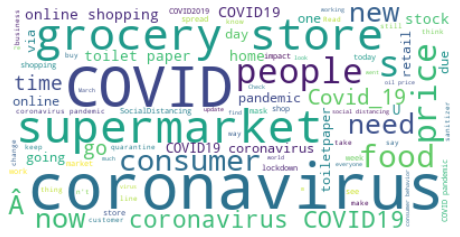

In [10]:
import matplotlib.pyplot as plt # for visualizing the data
from wordcloud import WordCloud, STOPWORDS
import itertools

print ("a few stop words: \n")
stopwords = set(STOPWORDS)# instantiate a word cloud object
stopwords.update({'https','will','t','co','amp'})
if use_stopwords == 0:
    stopwords = {}
for i, val in enumerate(itertools.islice(stopwords, 10)):
    print (val)
    
word_cloud = WordCloud(
    background_color='white',
    stopwords=stopwords
)# generate the word cloud

print ("\nword cloud for positively labeled items: ")
pos_string = (" ").join(pos_word_list)
word_cloud.generate(pos_string)
fig = plt.figure()
fig.set_figwidth(8) # set width
fig.set_figheight(10) # set height
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print ("\nword cloud for negatively labeled items: ")
neg_string = (" ").join(neg_word_list)
word_cloud.generate(neg_string)
fig = plt.figure()
fig.set_figwidth(8) # set width
fig.set_figheight(10) # set height
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print ("\nword cloud for neutral labeled items: ")
net_string = (" ").join(net_word_list)
word_cloud.generate(net_string)
fig = plt.figure()
fig.set_figwidth(8) # set width
fig.set_figheight(10) # set height
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Remove StopWords (Optional)

In [11]:
pos_word_list = [word for word in pos_word_list if word not in stopwords]
neg_word_list = [word for word in neg_word_list if word not in stopwords]
net_word_list = [word for word in net_word_list if word not in stopwords]
print (pos_word_list[:10])

['I', 'see', 'kinds', 'academics', 'already', 'whipping', '#', 'Covid_19', 'related', 'projects']


### Lemmatization (Optional)

##### Link: https://medium.com/@abhishekjainindore24/all-about-tokenization-stop-words-stemming-and-lemmatization-in-nlp-1620ffaf0f87

In [12]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
wl = WordNetLemmatizer()

if use_lemmatizer == 1:
    tmp_list = []
    for word in pos_word_list:
        tmp_list.append(wl.lemmatize(word))
    pos_word_list = tmp_list
    
    tmp_list = []
    for word in neg_word_list:
        tmp_list.append(wl.lemmatize(word))
    neg_word_list = tmp_list
    
    tmp_list = []
    for word in net_word_list:
        tmp_list.append(wl.lemmatize(word))
    net_word_list = tmp_list

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dishantgoyal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/dishantgoyal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Stemmer (Optional)

In [13]:
from nltk.stem import SnowballStemmer
snowballstemmer = SnowballStemmer("english")

if use_stemmer == 1:
    tmp_list = []
    for word in pos_word_list:
        tmp_list.append(snowballstemmer.stem(word))
    pos_word_list = tmp_list
    
    tmp_list = []
    for word in neg_word_list:
        tmp_list.append(snowballstemmer.stem(word))
    neg_word_list = tmp_list
    
    tmp_list = []
    for word in net_word_list:
        tmp_list.append(snowballstemmer.stem(word))
    net_word_list = tmp_list

### Add Bigrams as Additional Features   (Optional)

In [14]:
if use_bigrams == 1:
    bi_pos_word_list = list(nltk.bigrams(pos_word_list))
    pos_word_list   += bi_pos_word_list

    bi_neg_word_list = list(nltk.bigrams(neg_word_list))
    neg_word_list   += bi_neg_word_list

    bi_net_word_list = list(nltk.bigrams(net_word_list))
    net_word_list   += bi_net_word_list

    print (bi_pos_word_list[:5])
    print (pos_word_list[3690401:3690401+10])

### Count Each Word in Vocab of Each Class

In [15]:
from collections import Counter
pos_dict = dict(Counter(pos_word_list))    # probability of the word in the class = count/size_of_vocab
neg_dict = dict(Counter(neg_word_list))
net_dict = dict(Counter(net_word_list))

vocab_pos_len = len(pos_word_list)
vocab_neg_len = len(neg_word_list)
vocab_net_len = len(net_word_list)

full_vocab_len = len(set(pos_word_list + neg_word_list + net_word_list)) # unique words only (used for laplacian smoothening)
print (full_vocab_len)
print (vocab_pos_len)
print (vocab_neg_len)
print (vocab_net_len)

#print ("first item in dictionary of postive labeled tweets: ", list(pos_dict.keys())[0])
#print ("size of postively labeled tweets vocab: ", vocab_pos_len)

72116
461301
383656
322924


### Reading validation data from .csv file

In [16]:
import os
import pandas as pd

__location__ = os.path.realpath(os.path.join(os.getcwd(), "dataset_corona_sentiment/Corona_validation.csv"))
df_valid = pd.read_csv(__location__)

In [17]:
print ("number of rows    :", df_valid.shape[0])
print ("number of columns :", df_valid.shape[1])
print ("column values     :", list(df_valid.columns.values))

print ("\ndistribution of class lebels :", dict(df_valid['Sentiment'].value_counts()))
print ("\ndata frame: \n\n", df_valid, sep='\n')                                          # sep='\n' does not indent new line
print ("\nfirst row item  :", dict(df_valid.iloc[0]))

number of rows    : 3293
number of columns : 3
column values     : ['ID', 'Sentiment', 'CoronaTweet']

distribution of class lebels : {'Positive': 1444, 'Negative': 1232, 'Neutral': 617}

data frame: 


         ID Sentiment                                        CoronaTweet
0      7184  Negative  I reflected on my own consumer behaviour last ...
1     36363  Negative  I know everyone is getting stir crazy but befo...
2     10423  Negative  I haven t seen gas prices this low since I fir...
3      6409   Neutral  Only batmeat left on the supermarket shelves\r...
4      7015   Neutral  Along with health workers, we need to apprecia...
...     ...       ...                                                ...
3288  13685   Neutral  #day6 of #selfisolating but had to run quick e...
3289  17905  Positive  @Tesco do you think during the covid-19 pandem...
3290  40331   Neutral  Key insights into the effect of COVID - 19 on ...
3291   1495   Neutral  We scored a haul at the grocery store tonigh

### Converting to Lists

In [18]:
y_valid = list(df_valid['Sentiment'])
x_valid = list(df_valid['CoronaTweet'])

In [19]:
#print ("number of data points     :", len(x_valid))
#print ("number of class labels    :", len(y_valid))
assert(len(x_valid) == len(y_valid))

### Random Prediction & Accuracy

In [20]:
import random
y_valid_pred = []

classes = ['Positive', 'Negative', 'Neutral']
for index in range(0,df_valid.shape[0]):
    y_valid_pred.append(random.choice(classes))

#print ("first few randomly predicted class labels: ", y_valid_pred[:3])

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("PR Report (Random Prediction)        : \n", classification_report(y_valid, y_valid_pred, labels=classes, zero_division=0))
print("Confusion Matrix (Random Prediction) : \n", confusion_matrix(y_valid, y_valid_pred))
print("\nAccuracy (Random Prediction)       : ", accuracy_score(y_valid, y_valid_pred))

PR Report (Random Prediction)        : 
               precision    recall  f1-score   support

    Positive       0.42      0.33      0.37      1444
    Negative       0.36      0.31      0.34      1232
     Neutral       0.17      0.31      0.22       617

    accuracy                           0.32      3293
   macro avg       0.32      0.32      0.31      3293
weighted avg       0.35      0.32      0.33      3293

Confusion Matrix (Random Prediction) : 
 [[384 429 419]
 [194 190 233]
 [480 485 479]]

Accuracy (Random Prediction)       :  0.31976920740965686


In [22]:
y_valid_pred = []
for index in range(0,df_valid.shape[0]):
    y_valid_pred.append('Positive')

#print ("first few randomly predicted class labels: ", y_valid_pred[:3])

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("\nPR Report (All Positive Prediction)        : \n", classification_report(y_valid, y_valid_pred, labels=classes, zero_division=0))
print("\nConfusion Matrix (All Positive Prediction) : \n", confusion_matrix(y_valid, y_valid_pred))
print("\nAccuracy (All Positive Prediction)         : ", accuracy_score(y_valid, y_valid_pred))


PR Report (All Positive Prediction)        : 
               precision    recall  f1-score   support

    Positive       0.44      1.00      0.61      1444
    Negative       0.00      0.00      0.00      1232
     Neutral       0.00      0.00      0.00       617

    accuracy                           0.44      3293
   macro avg       0.15      0.33      0.20      3293
weighted avg       0.19      0.44      0.27      3293


Confusion Matrix (All Positive Prediction) : 
 [[   0    0 1232]
 [   0    0  617]
 [   0    0 1444]]

Accuracy (All Positive Prediction)         :  0.4385059216519891


### Naive-Bayes Prediction & Accuracy

In [24]:
import math

label_distribution = dict(df_valid['Sentiment'].value_counts())
label_probability  = {}
label_probability['Positive'] = math.log(label_distribution['Positive']/len(x_valid))
label_probability['Negative'] = math.log(label_distribution['Negative']/len(x_valid))
label_probability['Neutral']  = math.log(label_distribution['Neutral'] /len(x_valid))


y_valid_pred = []
    
for tweet in x_valid:
    pr_pos = label_probability['Positive']
    pr_neg = label_probability['Negative']
    pr_net = label_probability['Neutral']
    
    if use_tokenize == 1:
        word_list = word_tokenize(tweet)
    else:
        word_list = tweet.split()
        
    word_list = [word for word in word_list if word not in stopwords]
    if use_lemmatizer == 1:
        tmp_list = []
        for word in word_list:
            tmp_list.append(wl.lemmatize(word))
        word_list = tmp_list
        
    if use_stemmer == 1:
        tmp_list = []
        for word in word_list:
            tmp_list.append(snowballstemmer.stem(word))
        word_list = tmp_list
    
    if use_bigrams == 1:
        bi_word_list = list(nltk.bigrams(word_list))
        word_list   += bi_word_list
    
    for word in word_list:     # using log() to avoid underflow errors
        if word in pos_dict:
            pr_pos += math.log((pos_dict[word]+1*use_lap_smooth)/(full_vocab_len*use_lap_smooth + vocab_pos_len))      # included laplacian smoothning
        else:
            pr_pos += use_lap_smooth*math.log(1/(full_vocab_len))
            
        if word in neg_dict:
            pr_neg += math.log((neg_dict[word]+1*use_lap_smooth)/(full_vocab_len*use_lap_smooth + vocab_neg_len))      # included laplacian smoothning
        else:
            pr_neg += use_lap_smooth*math.log(1/(full_vocab_len))
            
        if word in net_dict:
            pr_net += math.log((net_dict[word]+1*use_lap_smooth)/(full_vocab_len*use_lap_smooth + vocab_net_len))      # included laplacian smoothning
        else:
            pr_net += use_lap_smooth*math.log(1/(full_vocab_len))        

    if pr_pos >= pr_neg and pr_pos >= pr_net:
        y_valid_pred.append('Positive')
    elif pr_neg >= pr_pos and pr_neg >= pr_net:
        y_valid_pred.append('Negative')
    else:
        y_valid_pred.append('Neutral')

# print ("a first few predicted labels: ", y_valid_pred[:10])      

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("PR Report         : \n", classification_report(y_valid, y_valid_pred, labels=classes, zero_division=0))
print("Confusion Matrix  : \n", confusion_matrix(y_valid, y_valid_pred))
print("\nAccuracy        : ", accuracy_score(y_valid, y_valid_pred))

PR Report         : 
               precision    recall  f1-score   support

    Positive       0.70      0.75      0.72      1444
    Negative       0.72      0.69      0.71      1232
     Neutral       0.53      0.46      0.49       617

    accuracy                           0.68      3293
   macro avg       0.65      0.64      0.64      3293
weighted avg       0.67      0.68      0.67      3293

Confusion Matrix  : 
 [[ 855  116  261]
 [ 116  286  215]
 [ 217  137 1090]]

Accuracy        :  0.6774977224415427
